In [9]:
import streamlit as st
import cv2
import numpy as np
from PIL import Image
import time
import os
import json
import matplotlib.pyplot as plt

import torch

from model import EAST
from detect import detect

In [10]:
def load_model(model_file):
    model = EAST(pretrained=False).to('cpu')
    model.load_state_dict(torch.load(model_file, map_location='cpu'))
    model.eval()

    return model

In [11]:
def do_inference(model, img, input_size=2048):

    image_fnames, by_sample_bboxes = [], []

    
    # img = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0)
    
    image_fnames, by_sample_bboxes = ['test'], []
    images = []
    images.append(img)
    
    by_sample_bboxes.extend(detect(model, images, input_size))
    #st.text(by_sample_bboxes)
    ufo_result = dict(images=dict())
    for image_fname, bboxes in zip(image_fnames, by_sample_bboxes):
        words_info = {idx: dict(points=bbox.tolist()) for idx, bbox in enumerate(bboxes)}
        ufo_result['images'][image_fname] = dict(words=words_info)

    return ufo_result

Load Anotation Data

In [12]:
with open(os.path.join('/opt/ml/input/data/medical', 'ufo/val.json'), 'r') as f:
    anno = json.load(f)

print(list(anno['images'].keys()))

['drp.en_ko.in_house.deepnatural_002231.jpg', 'drp.en_ko.in_house.deepnatural_002421.jpg', 'drp.en_ko.in_house.deepnatural_002437.jpg', 'drp.en_ko.in_house.deepnatural_002462.jpg', 'drp.en_ko.in_house.deepnatural_002466.jpg', 'drp.en_ko.in_house.deepnatural_002470.jpg', 'drp.en_ko.in_house.deepnatural_002486.jpg', 'drp.en_ko.in_house.deepnatural_002500.jpg', 'drp.en_ko.in_house.deepnatural_002522.jpg', 'drp.en_ko.in_house.deepnatural_002541.jpg', 'drp.en_ko.in_house.deepnatural_002611.jpg', 'drp.en_ko.in_house.deepnatural_002629.jpg', 'drp.en_ko.in_house.deepnatural_002636.jpg', 'drp.en_ko.in_house.deepnatural_002653.jpg', 'drp.en_ko.in_house.deepnatural_002676.jpg', 'drp.en_ko.in_house.deepnatural_002691.jpg', 'drp.en_ko.in_house.deepnatural_002693.jpg', 'drp.en_ko.in_house.deepnatural_002713.jpg', 'drp.en_ko.in_house.deepnatural_002721.jpg', 'drp.en_ko.in_house.deepnatural_002727.jpg', 'drp.en_ko.in_house.deepnatural_002731.jpg', 'drp.en_ko.in_house.deepnatural_002750.jpg', 'drp.en_k

In [13]:
data_dir = "/opt/ml/input/data/medical/img/val/"
img_name = "drp.en_ko.in_house.deepnatural_002231.jpg"
img_path = os.path.join(data_dir,img_name)

ignore_tags = ['masked', 'excluded-region', 'maintable', 'stamp']

weights = "/opt/ml/input/code/trained_models/0.956.pth"


In [14]:
vertices, labels = [],[]
for word_info in anno['images'][img_name]['words'].values():
    word_tags = word_info['tags']

    ignore_sample = any(elem for elem in word_tags if elem in ignore_tags)
    num_pts = np.array(word_info['points']).shape[0]

    # skip samples with ignore tag and
    # samples with number of points greater than 4
    if ignore_sample or num_pts > 4:
        continue

    vertices.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
    
vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)
# word_bboxes = np.reshape(vertices, (-1, 4, 2))
vertices.shape

(381, 4, 2)

In [15]:

model = load_model(weights)

img = np.array(Image.open(img_path))
fin_img = img.copy()

ufo_result = do_inference(model, img)



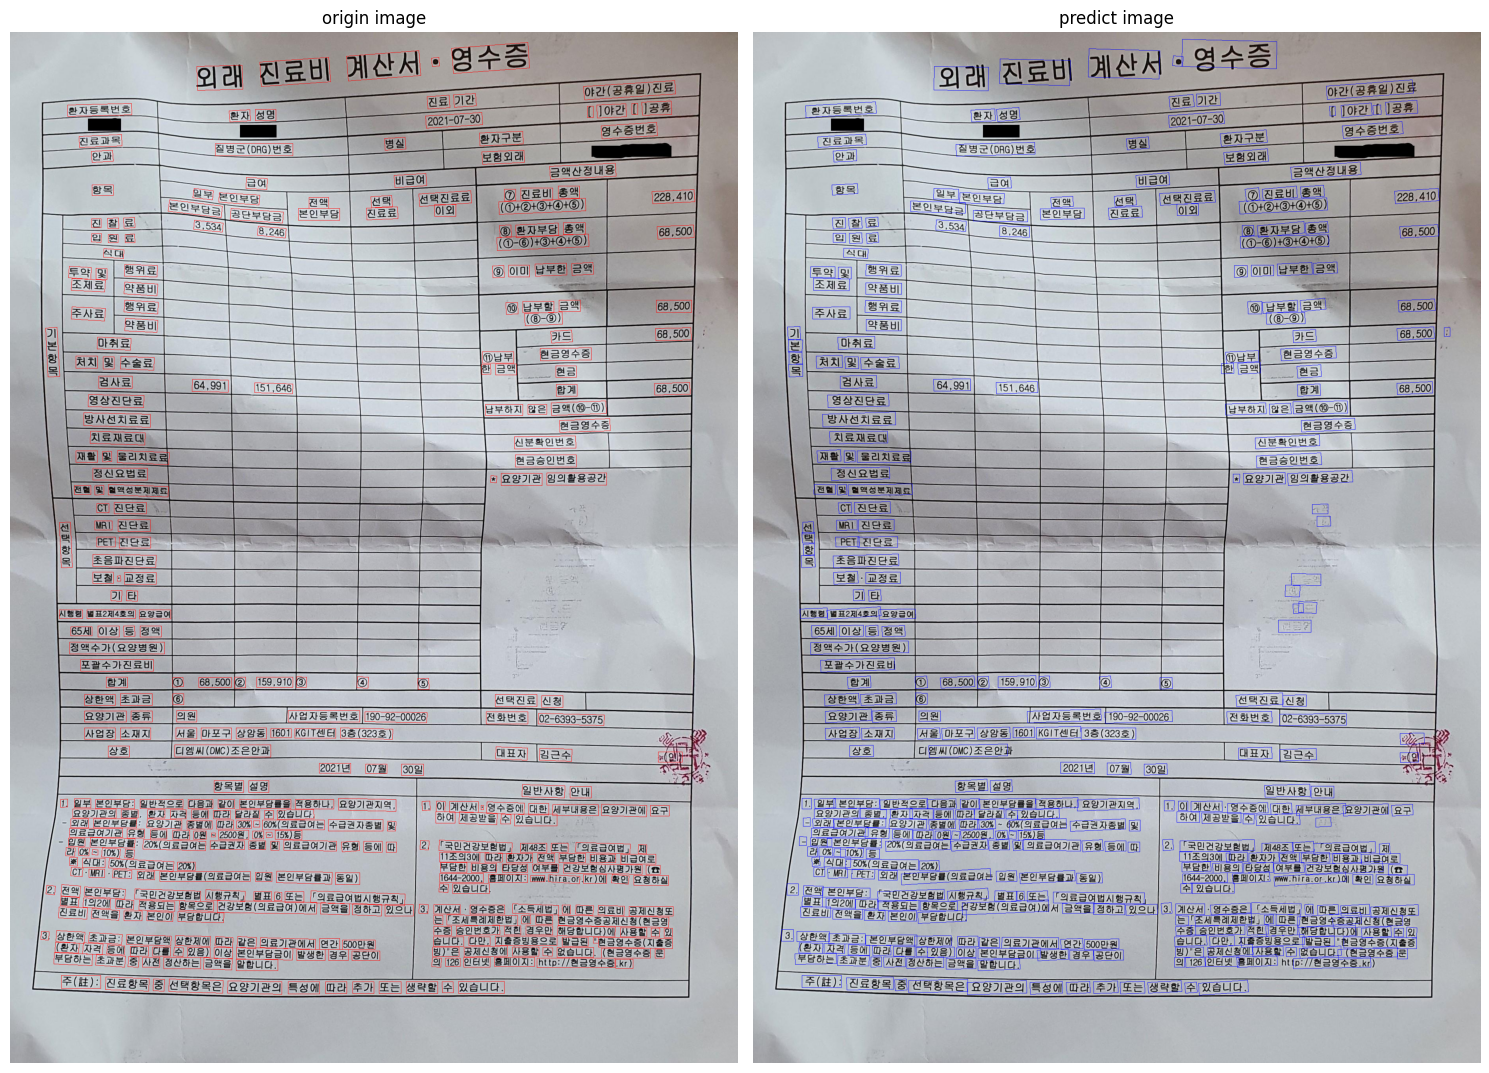

In [18]:
for _, v in ufo_result['images']['test']['words'].items():
    v = v['points']
    v.append(v[0])
    cv2.polylines(fin_img, [np.array(v, dtype=np.int32)], True, (0, 0, 255), 1)
    
for polygon in vertices:
    cv2.polylines(img, [np.array(polygon, dtype=np.int32)], True, (255,0,0),1)
    
fig , axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(img)
axs[0].set_title("origin image")
axs[0].axis('off')

axs[1].imshow(fin_img)
axs[1].set_title("predict image")
axs[1].axis('off')

plt.tight_layout()
plt.show()